In [1]:
import xarray as xr
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

In [2]:
############################
# set up 
############################
#
feature_data          = '/glade/work/hardt/ds612/model2_05minuteAfterHour_3D_refl_shuffled_scaled-v6.nc'
label_data            = '/glade/work/hardt/ds612/model2_composite_W_shuffled_scaled-v6.nc'
#
model_root      = '/glade/work/hardt/models'
model_run       = 'unet_v6p1'
#
# version used for image save directory
#
version         = 'unet_v6p1_3'
#
predict_file    = 'predict-test-trained_model_feature-05minAfterHour_refl_2021_01_30_01_53.h5.nc'
predict_ID      = 'predict-test-2021_01_30_01_53'
#
job_number      = '5minOffset'
#
BATCH_SIZE = 32
#
data_fraction_for_test = 0.1
#
label_scale_min  = -0.01209001
label_scale_99p9 = 1.0441561281681
#
############################

In [3]:
fds = xr.open_dataset(feature_data)
f = fds.REFL_10CM.values

lds = xr.open_dataset(label_data)
l = lds.W.values

t = lds.XTIME.values

In [4]:
print(f.shape)
print(l.shape)

(4896, 10, 256, 256)
(4896, 256, 256)


In [5]:
#
# Matching this data to the test data
# that went into the prediction
#
num_images = f.shape[0]
#
test_data_start = int(num_images * (1 - data_fraction_for_test))
test_data_start = (num_images - int((num_images - test_data_start) / BATCH_SIZE) * BATCH_SIZE) 
test_data_end = num_images
#
print ("Number of images:", num_images)
print ("Test data start image:", test_data_start)
print ("Test data end image:", test_data_end)#print ("Number of images used:", num_images - test_data_start)
#

Number of images: 4896
Test data start image: 4416
Test data end image: 4896


In [6]:
#
# composite
#
f = np.max(f[test_data_start:test_data_end,:,:,:], axis=1)
#
l = l[test_data_start:test_data_end,:,:]
#
t = t[test_data_start:test_data_end]
#
print(f.shape)

(480, 256, 256)


In [7]:
#predict_file    = 'predict_trained_model_feature-0to6.5km_at_500m_steps_label-5500m_2020_10_17_00_44.h5.nc'

model_run_dir = os.path.join(model_root, model_run)
predict_data = os.path.join(model_run_dir, predict_file)

pds = xr.open_dataset(predict_data)
p = pds.pW.values

In [8]:
print(p.shape)
print(f.shape)
print(l.shape)

(480, 256, 256, 1)
(480, 256, 256)
(480, 256, 256)


In [9]:
#
# set up lat lon arrays
#
input_dir = '/glade/work/hardt/ds612'
#
latlon_filename = 'model2_latlon_coord.nc'
latlonFile = os.path.join(input_dir, latlon_filename)
#
latlon_ds = xr.open_mfdataset(latlonFile, combine='by_coords')
lat = latlon_ds.XLAT[0,:,:].values
lon = latlon_ds.XLONG[0,:,:].values

In [10]:
# 6-10, 50-51, 154, 507, 511, 500 (30???)
#
# v6p1 scaling
#
# 'refl_scaling_min': -35.0,
# 'refl_scaling_per99.99': 58.4954728,
# 'W_scaling_min': -14.297869,
# 'W_scaling_per99.99': 1.31273185,
#
# v6p2 scaling
#
# 'refl_scaling_min': -35.0,
# 'refl_scaling_per99.99': 58.4732837,
# 'W_scaling_min': -14.297869,
# 'W_scaling_per99.99': 1.31273185,

lmax = 1.31273185
lmin = -14.297869

plt_number = 387
fi = f[plt_number,:,:]
li = l[plt_number,:,:]
pi = p[plt_number,:,:,0]

#li = li * (lmax - lmin) + lmin
#pi = pi * (lmax - lmin) + lmin

#
#get the data time string
#
l_t = lds.XTIME[plt_number].values
#
year = str(l_t)[0:4]
month = str(l_t)[5:7]
day = str(l_t)[8:10]
hour = str(l_t)[11:13]
minute = str(l_t)[14:16]
full_datetime_string = year + month + day + " " + hour + ':' + minute + ' ' + 'UTC'
yearMonthDay = year + month + day
print(full_datetime_string)

20130610 09:00 UTC


In [11]:
print(pi.shape)
print(np.amin(li[:,:]))
print(np.amax(li[:,:]))
print(np.amin(pi[:,:]))
print(np.amax(pi[:,:]))

(256, 256)
0.018735623
7.424231
0.116970874
0.20956765


In [12]:

print(fi[0,0])
print(li[0,0])

print(fi[250,0])
print(li[250,0])

0.0
0.035220634
0.6773574
0.15288554


0.018735623 7.424231 0.05166727118194103 1.5881446629763447
0.116970874
0.20956765
0.20956765115261078


<Figure size 432x288 with 0 Axes>

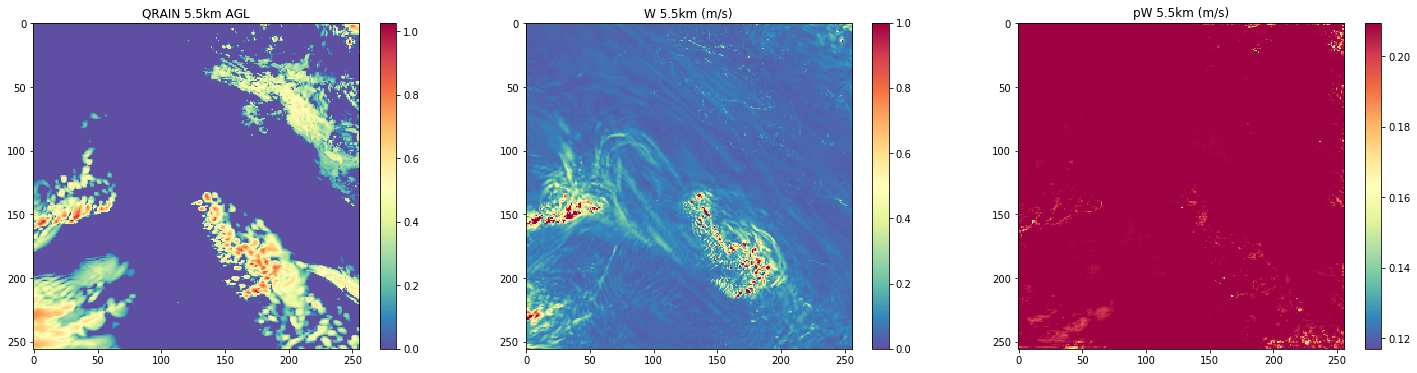

In [13]:
cmap = plt.cm.Spectral_r
plt.clf()

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(25,6)) 

max_ref = np.amax(fi[:,:])
p_ref = np.percentile(fi[:,:], 99.9)

ref = ax1.imshow(fi, cmap=cmap)
#ax1.set_title("max QRAIN 0-6.5km AGL")
ax1.set_title("QRAIN 5.5km AGL")
#ref.set_clim(vmin=0, vmax=max_ref)
ref.set_clim()
fig.colorbar(ref, ax=ax1, orientation='vertical', label='')

max_maxW = np.amax(li[:,:])
min_maxW = np.amin(li[:,:])
p_maxW = np.percentile(li[:,:], 99.9)
pmin_maxW = np.percentile(li[:,:], 35.0)
print(min_maxW, max_maxW, pmin_maxW, p_maxW)

maxW = ax2.imshow(li, cmap=cmap)
ax2.set_title("W 5.5km (m/s)")
#maxW.set_clim(vmin=0, vmax=p_maxW)
maxW.set_clim(0,1)
fig.colorbar(maxW, ax=ax2)

min_pMaxW = np.amin(pi[:,:])
max_pMaxW = np.amax(pi[:,:])
p_pMaxW = np.percentile(pi[:,:], 99)
print(min_pMaxW)
print(max_pMaxW)
print(p_pMaxW)

pMaxW = ax3.imshow(pi, cmap=cmap)
ax3.set_title("pW 5.5km (m/s)")
#pMaxW.set_clim(vmin=0, vmax=1)
pMaxW.set_clim()
fig.colorbar(pMaxW, ax=ax3)

#plt.savefig(model_run_dir + "/predict_comp_" + job_number + "_" + str(plt_number) + ".png")

In [14]:
#
# changes to the colormap
#
from matplotlib.colors import ListedColormap

cmap = plt.cm.get_cmap('Spectral_r', 256)
newcolors = cmap(np.linspace(0, 1, 256))
pink = np.array([248/256, 24/256, 148/256, 1])
lt_gray = np.array([240/256, 240/256, 240/256, 1])
newcolors[:1, :] = lt_gray
mycmap = ListedColormap(newcolors)
#print(newcmap(range(12)))
#print('newcmap(np.linspace(0, 1, 12))', newcmp(np.linspace(0, 1, 12)))

Writing image to output file /glade/work/hardt/models/unet_v6p1/predict-unet_v6p1-20130610-image387.png



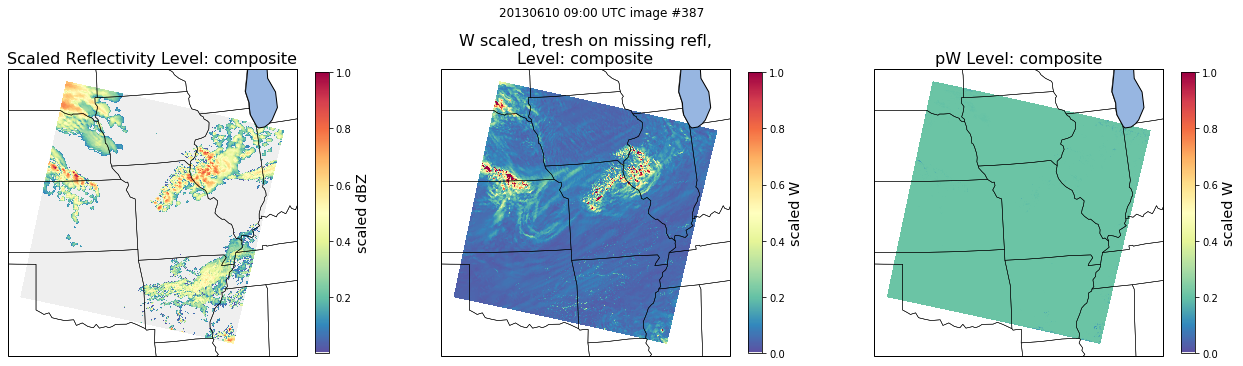

In [15]:
import cartopy.crs as ccrs
import cartopy.feature as cf

composite_refl = True
composite_W = True

#
# images with geo-referencing
#

def plot_background(ax):
    #ax.set_extent([235., 290., 20., 55.])
    #ax.set_extent([-102, -85, 30, 45])
    ax.add_feature(cf.COASTLINE.with_scale('50m'), linewidth=0.5)
    ax.add_feature(cf.STATES, linewidth=0.5)
    ax.add_feature(cf.BORDERS, linewidth=0.5)
    ax.add_feature(cf.OCEAN)
    ax.add_feature(cf.LAKES, edgecolor='black')
    ax.add_feature(cf.LAND, facecolor='white', edgecolor='none')
    #ax.add_feature(cf.LAND, facecolor='wheat', edgecolor='none')

    return ax

#
# set up plot
#
crs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=45.0)
#
#cmap = plt.cm.Spectral_r
cmap=mycmap
#
fig, axarr = plt.subplots(nrows=1, ncols=3, figsize=(22, 6), subplot_kw={'projection': crs})
fig.suptitle(full_datetime_string + ' image #' + str(plt_number))
#
axlist = axarr.flatten()
for ax in axlist:
    plot_background(ax)
#
# fi (feature image)
#
if composite_refl:
    cf1 = axlist[0].pcolormesh(lon, lat, fi, cmap=cmap, transform = ccrs.PlateCarree())
    axlist[0].set_title('Scaled Reflectivity Level: composite', fontsize=16)
else:
    cf1 = axlist[0].pcolormesh(lon, lat, fi, cmap=cmap, transform = ccrs.PlateCarree())
    axlist[0].set_title('Scaled Reflectivity Level: ' + str(refl_height+1) + ' of 10', fontsize=16)
#
cb1 = fig.colorbar(cf1, ax=axlist[0], orientation='vertical', shrink=0.86, pad=0.05)#, cmap=cmap)#, norm=norm, ticks=bounds)
cb1.mappable.set_clim(0.001,1)
cb1.set_label('scaled dBZ', size='x-large')
#
# Plotting li (label image)
#
cf2 = axlist[1].pcolormesh(lon, lat, li, cmap=cmap, transform = ccrs.PlateCarree())
if composite_W:
    axlist[1].set_title('W scaled, tresh on missing refl,\nLevel: composite', fontsize=16)
else:
    axlist[1].set_title('W Level: ' + str(W_height+1) + ' of 51', fontsize=16)
#
cb2 = fig.colorbar(cf2, ax=axlist[1], orientation='vertical', shrink=0.86, pad=0.05, 
                   cmap=cmap)#, norm=norm, ticks=bounds, extend='both', boundaries=[-10] + bounds + [10], spacing='uniform', extendfrac='auto')
cb2.mappable.set_clim(0,1.0)
cb2.set_label('scaled W', size='x-large')
#
# Plotting pi (predicted image)
#
cf3 = axlist[2].pcolormesh(lon, lat, pi, cmap=cmap, transform = ccrs.PlateCarree())
if composite_W:
    axlist[2].set_title('pW Level: composite', fontsize=16)
else:
    axlist[2].set_title('pW Level: ' + str(W_height+1) + ' of 51', fontsize=16)
#
cb3 = fig.colorbar(cf3, ax=axlist[2], orientation='vertical', shrink=0.86, pad=0.05, 
                   cmap=cmap)#, norm=norm, ticks=bounds, extend='both', boundaries=[-10] + bounds + [10], spacing='uniform', extendfrac='auto')
cb3.mappable.set_clim(0,1)
cb3.set_label('scaled W', size='x-large')

output_filename = 'predict-' + model_run + '-' + yearMonthDay
output_filename = output_filename + '-image' + str(plt_number) + '.png'
of = os.path.join(model_run_dir, output_filename)
#
# Write output file
#
print('Writing image to output file', of)
print()
#plt.savefig(of)

In [16]:
#
# put in time order
#
print(p.shape[0])
#
s = np.argsort(t)
#
print(s.shape)
#print(t)
#print(t[s])
#
t = t[s]
f = f[s]
l = l[s]
p = p[s]
print('DONE')

480
(480,)
DONE


Writing image to output file /glade/work/hardt/models/unet_v6p1/images_unet_v6p1_3/20150529_2100-predict-test-2021_01_30_01_53.png



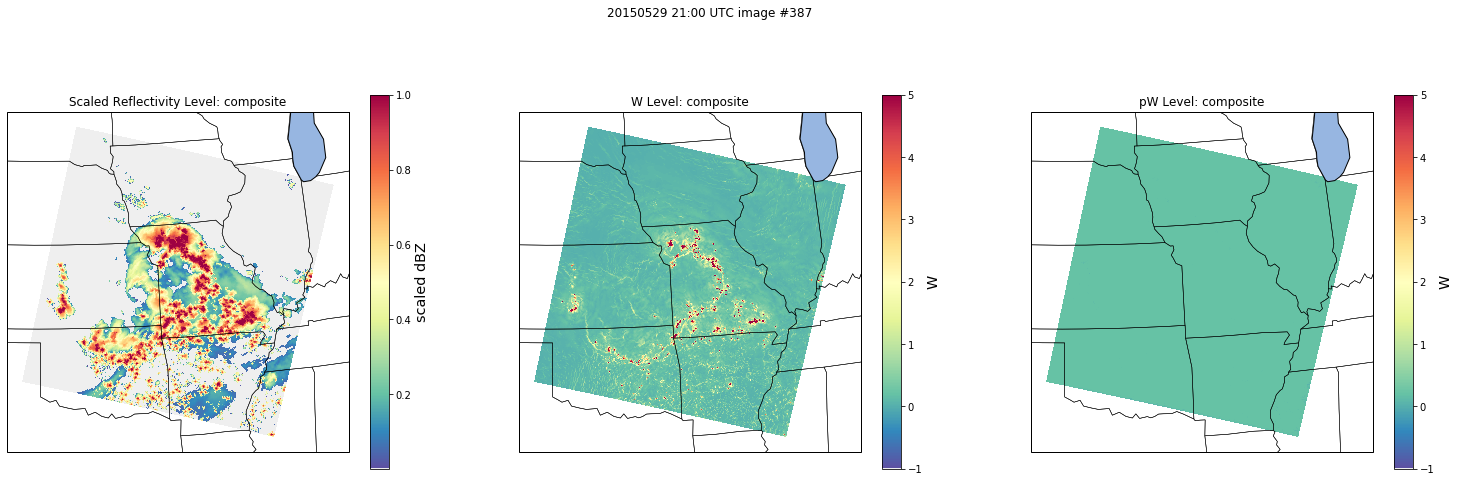

In [17]:
from celluloid import Camera
import ffmpeg

composite_refl = True
composite_W = True
    
fontsize=12

#
# images with geo-referencing
#

def plot_background(ax):
    #ax.set_extent([235., 290., 20., 55.])
    #ax.set_extent([-102, -85, 30, 45])
    ax.add_feature(cf.COASTLINE.with_scale('50m'), linewidth=0.5)
    ax.add_feature(cf.STATES, linewidth=0.5)
    ax.add_feature(cf.BORDERS, linewidth=0.5)
    ax.add_feature(cf.OCEAN)
    ax.add_feature(cf.LAKES, edgecolor='black')
    ax.add_feature(cf.LAND, facecolor='white', edgecolor='none')
    #ax.add_feature(cf.LAND, facecolor='wheat', edgecolor='none')

    return ax
#
# set up plot
#
crs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=45.0)
#
#cmap = plt.cm.Spectral_r
cmap=mycmap
#
#fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))   
#fig, axarr = plt.subplots(nrows=1, ncols=3, figsize=(16, 5), subplot_kw={'projection': crs})
#
#camera = Camera(fig)
#
#
# full image
#
d1_s = 0
d1_e = 256
d2_s = 0
d2_e = 256
#
# 80 x 80 image
#
#d1_s = 155
#d1_e = 235
#d2_s = 55
#d2_e = 135
#
# select the range
#
#image_range = range(0, p.shape[0], 1)
image_range = range(387, 388, 1)
#
for i in image_range:
    
    #
    # get the data for each image
    #
    plt_number = i
    fi = f[plt_number,d1_s:d1_e,d2_s:d2_e]
    li = l[plt_number,d1_s:d1_e,d2_s:d2_e]
    pi = p[plt_number,d1_s:d1_e,d2_s:d2_e,0]
    loni = lon[d1_s:d1_e,d2_s:d2_e]
    lati = lat[d1_s:d1_e,d2_s:d2_e]
    #
    # unscale the l and p data
    #
    li = ( li * (label_scale_99p9 - label_scale_min) ) + label_scale_min 
    pi = ( pi * (label_scale_99p9 - label_scale_min) ) + label_scale_min
    #
    # get the data time string
    #
    l_t = t[plt_number]
    #
    year = str(l_t)[0:4]
    month = str(l_t)[5:7]
    day = str(l_t)[8:10]
    hour = str(l_t)[11:13]
    minute = str(l_t)[14:16]
    #
    full_datetime_string = year + month + day + " " + hour + ':' + minute + ' ' + 'UTC'
    yearMonthDay = year + month + day
    #
    #print(full_datetime_string)
    #
    file_dt = year + month + day + "_" + hour + minute
    #print(file_dt)

    #
    # start the plot
    #
    #
    #fig, axarr = plt.subplots(nrows=1, ncols=3, figsize=(16, 5), subplot_kw={'projection': crs})
    fig, axarr = plt.subplots(nrows=1, ncols=3, figsize=(26, 8), subplot_kw={'projection': crs})
    fig.suptitle(full_datetime_string + ' image #' + str(plt_number))
    #
    axlist = axarr.flatten()
    for ax in axlist:
        plot_background(ax)
    #
    # fi (feature image)
    #
    if composite_refl:
        cf1 = axlist[0].pcolormesh(loni, lati, fi, cmap=cmap, transform = ccrs.PlateCarree())
        axlist[0].set_title('Scaled Reflectivity Level: composite', fontsize=fontsize)
    else:
        cf1 = axlist[0].pcolormesh(loni, lati, fi, cmap=cmap, transform = ccrs.PlateCarree())
        axlist[0].set_title('Scaled Reflectivity Level: ' + str(refl_height+1) + ' of 10', fontsize=fontisize)
    #
    #
    #
    #
    cb1 = fig.colorbar(cf1, ax=axlist[0], orientation='vertical', shrink=0.86, pad=0.05)#, cmap=cmap)#, norm=norm, ticks=bounds)
    cb1.mappable.set_clim(0.001,1)
    cb1.set_label('scaled dBZ', size='x-large')
    #
    #
    #
    #
    # Plotting li (label image)
    #
    cf2 = axlist[1].pcolormesh(loni, lati, li, cmap=cmap, transform = ccrs.PlateCarree())
    if composite_W:
        axlist[1].set_title('W Level: composite', fontsize=fontsize)
    else:
        axlist[1].set_title('W Level: ' + str(W_height+1) + ' of 51', fontsize=fontsize)
    #
    #
    #
    cb2 = fig.colorbar(cf2, ax=axlist[1], orientation='vertical', shrink=0.86, pad=0.05, cmap=cmap)#, norm=norm, ticks=bounds, extend='both', boundaries=[-10] + bounds + [10], spacing='uniform', extendfrac='auto')
    cb2.mappable.set_clim(-1,5)
    cb2.set_label('W', size='x-large')
    #
    #
    #
    #
    # Plotting pi (predicted image)
    #
    cf3 = axlist[2].pcolormesh(loni, lati, pi, cmap=cmap, transform = ccrs.PlateCarree())
    if composite_W:
        axlist[2].set_title('pW Level: composite', fontsize=fontsize)
    else:
        axlist[2].set_title('pW Level: ' + str(W_height+1) + ' of 51', fontsize=fontsize)
    #
    #
    #
    cb3 = fig.colorbar(cf3, ax=axlist[2], orientation='vertical', shrink=0.86, pad=0.05, cmap=cmap)#, norm=norm, ticks=bounds, extend='both', boundaries=[-10] + bounds + [10], spacing='uniform', extendfrac='auto')
    cb3.mappable.set_clim(-1, 5)
    cb3.set_label('W', size='x-large')
    #
    #camera.snap()

    output_filename = file_dt +'-' + predict_ID + '.png'
    #output_filename = file_dt +'-' + predict_ID + '-sub_domain.png'

    #output_path = os.path.join(model_run_dir, 'images')
    output_path = os.path.join(model_run_dir, 'images_' + version)
    
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    of = os.path.join(output_path, output_filename)
    #
    # Write output file
    #
    print('Writing image to output file', of)
    print()
    plt.savefig(of)
    #fig.clf()


In [18]:
#animation = camera.animate(interval=500, repeat_delay=1000, repeat=20)
#output_file = os.path.join(output_path, predict_ID + '.gif')
#animation.save(output_file, writer = 'imagemagick')